https://www.kaggle.com/eikedehling/tune-and-compare-xgb-lightgbm-rf-with-hyperopt

In [6]:
from __future__ import print_function

In [60]:
import sklearn
import numpy
import catboost
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import colorama
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb

In [12]:
# Read train and test files
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [13]:
y = train_df['target']
X = train_df.drop(['ID_code', 'target'], axis=1)

X_test = test_df.drop(['ID_code'], axis=1)
X_test.fillna(999, inplace = True)

In [17]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8,  random_state=1234)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [29]:
def gini(truth, predictions):
    g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(truth) + 1) / 2.
    return gs / len(truth)

def gini_xgb(predictions, truth):
    truth = truth.get_label()
    return 'gini', -1.0 * gini(truth, predictions) / gini(truth, truth)

def gini_lgb(truth, predictions):
    score = gini(truth, predictions) / gini(truth, truth)
    return 'gini', score, True

def gini_sklearn(truth, predictions):
    return gini(truth, predictions) / gini(truth, truth)

gini_scorer = make_scorer(gini_sklearn, greater_is_better=True, needs_proba=True)

## Random Forest

In [37]:
def objective(params):
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth'])}
    
    clf = RandomForestClassifier(n_jobs=4, class_weight={0:1, 1:8}, **params)
    
    score = cross_val_score(clf, X, y, scoring='roc_auc', cv=StratifiedKFold(n_splits = 5)).mean()
    print("Gini {:.3f} params {}".format(score, params))
    return score

space = {
    'n_estimators': hp.quniform('n_estimators', 25, 500, 25),
    'max_depth': hp.quniform('max_depth', 1, 10, 1)
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

Gini 0.782 params {'n_estimators': 300, 'max_depth': 5}
Gini 0.768 params {'n_estimators': 450, 'max_depth': 2}
Gini 0.789 params {'n_estimators': 375, 'max_depth': 6}
Gini 0.772 params {'n_estimators': 100, 'max_depth': 4}
Gini 0.803 params {'n_estimators': 300, 'max_depth': 9}
Gini 0.755 params {'n_estimators': 325, 'max_depth': 1}
Gini 0.766 params {'n_estimators': 300, 'max_depth': 2}
Gini 0.778 params {'n_estimators': 50, 'max_depth': 6}
Gini 0.795 params {'n_estimators': 400, 'max_depth': 7}
Gini 0.766 params {'n_estimators': 50, 'max_depth': 3}


In [39]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'max_depth': 1.0, 'n_estimators': 325.0}


In [41]:
rfc = RandomForestClassifier(n_jobs=4, class_weight={0:1, 1:8}, n_estimators = 325, max_depth = 1 )

In [43]:
rfc.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 8},
            criterion='gini', max_depth=1, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=325, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [ ]:
rfc_cv = cross_val_score(rfc, X, y, scoring='roc_auc', cv=StratifiedKFold(n_splits = 5)).mean()

In [70]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [72]:
from sklearn.base import clone 

def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

In [77]:
drop_col_feat_imp(rfc, X_train, y_train, random_state = 42)

NameError: name 'imp_df' is not defined

In [48]:
import matplotlib.pyplot as plt

In [66]:
importances = rfc.feature_importances_



In [69]:
importances[1:2:3]

array([0.00615385])

In [67]:
type(importances)

numpy.ndarray

Feature ranking:
1. feature 53 (0.073846)
2. feature 81 (0.070769)
3. feature 12 (0.058462)
4. feature 139 (0.058462)
5. feature 110 (0.058462)
6. feature 146 (0.055385)
7. feature 26 (0.055385)
8. feature 22 (0.049231)
9. feature 174 (0.036923)
10. feature 109 (0.033846)
11. feature 80 (0.033846)
12. feature 6 (0.024615)
13. feature 99 (0.021538)
14. feature 76 (0.021538)
15. feature 44 (0.021538)
16. feature 21 (0.021538)
17. feature 166 (0.021538)
18. feature 165 (0.018462)
19. feature 198 (0.015385)
20. feature 40 (0.015385)
21. feature 133 (0.015385)
22. feature 2 (0.015385)
23. feature 0 (0.015385)
24. feature 179 (0.015385)
25. feature 13 (0.012308)
26. feature 115 (0.012308)
27. feature 164 (0.012308)
28. feature 33 (0.009231)
29. feature 78 (0.009231)
30. feature 123 (0.009231)
31. feature 191 (0.009231)
32. feature 177 (0.009231)
33. feature 92 (0.009231)
34. feature 190 (0.006154)
35. feature 170 (0.006154)
36. feature 184 (0.006154)
37. feature 1 (0.006154)
38. feature 108 

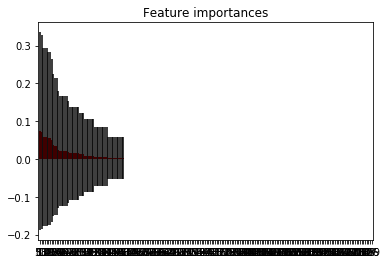

In [51]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## XGB

In [ ]:
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
       'n_estimators': int(params['n_estimators']),
     #   'gamma': "{:.3f}".format(params['gamma']),
      #  'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    
    clf = xgb.XGBClassifier(
        #n_estimators=250,
        learning_rate=0.1,
        class_weight={0:1, 1:8},
        n_jobs=2,
        **params
    )
    
    score = cross_val_score(clf, X, y, scoring='roc_auc', cv=StratifiedKFold(n_splits = 5)).mean()
    print("Gini {:.3f} params {}".format(score, params))
    return score

space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'n_estimators': hp.quniform('n_estimators', 500, 2500, 100),
   # 'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
   # 'gamma': hp.uniform('gamma', 0.0, 0.5),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

https://www.kaggle.com/dreeux/hyperparameter-tuning-using-hyperopt

https://www.kaggle.com/eikedehling/tune-and-compare-xgb-lightgbm-rf-with-hyperopt

In [ ]:
p